# **Model Testing** - Text Only

In [1]:
# pip install -U sentence-transformers

In [2]:
import mysql.connector 
import numpy as np
import pandas as pd
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema

import pickle


In [3]:
bills_db = DbSchema(config)


In [4]:
#Query all titles and Passing

df = bills_db.query("""
    SELECT
        cb.Title,
        cb.PassH
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >=110
    """)
df.head()

,Title,PassH
0,To provide for the implementation of the recom...,1
1,Reserved for Speaker.,0
2,To amend the Higher Education Act of 1965 to p...,0
3,To award a congressional gold medal to Edward ...,0
4,To amend the Haitian Hemispheric Opportunity t...,0


In [5]:
df.shape

(51067, 2)

In [6]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

# **Tokenizer:**

In [7]:
import spacy
from spacy.lang.en import English
import en_core_web_sm
import string
import re

In [8]:
nlp = English()

stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [9]:
def tokenizer(text):
    
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

# Apply Tokenizer to Title Text

In [10]:
df['tokenized_title']=df['Title'].apply(lambda x: tokenizer(x))

In [11]:
df.head()

,Title,PassH,tokenized_title
0,To provide for the implementation of the recom...,1,"[implementation, recommendation, national, com..."
1,Reserved for Speaker.,0,"[reserve, speaker]"
2,To amend the Higher Education Act of 1965 to p...,0,"[high, education, prevent, veteran, contributi..."
3,To award a congressional gold medal to Edward ...,0,"[award, congressional, gold, medal, edward, wi..."
4,To amend the Haitian Hemispheric Opportunity t...,0,"[haitian, hemispheric, opportunity, partnershi..."


In [12]:
# for_pickle = df.drop(columns='Title')

In [13]:

# #is it vectorizer or transformed?
# tk_titles = 'tokenized_titles.sav'
# pickle.dump(for_pickle, open(tk_titles, 'wb'))
 

Unpickle Tokenized Text

In [16]:
# load the model from disk
test_1 = pickle.load(open('tokenized_titles.sav', 'rb'))
test_1.head()

,PassH,tokenized_title
0,1,"[implementation, recommendation, national, com..."
1,0,"[reserve, speaker]"
2,0,"[high, education, prevent, veteran, contributi..."
3,0,"[award, congressional, gold, medal, edward, wi..."
4,0,"[haitian, hemispheric, opportunity, partnershi..."


# **Modeling**

Import packages:

- CountVectorizer
- TFIDF

- Naive Bayes
- Logistic Regression
- Random Forest

**Remember to look at feature importances!

In [17]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher


**Train test split** - Tokenized Text

In [18]:
"""PRE TOKENIZED TEXT"""

from sklearn.model_selection import train_test_split

X = test_1['tokenized_title']
y = test_1['PassH']


In [19]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=2)

In [20]:
X_train.head()

23216    [title, vi, food, drug, cosmetic, ensure, safe...
48008    [allow, woman, great, access, safe, effective,...
36918    [title, xviii, social, security, treatment, au...
44287    [direct, administrator, aviation, administrati...
20528    [financial, incentive, regulatory, framework, ...
Name: tokenized_title, dtype: object

In [21]:
X_train.shape

(40853,)

**Train test split** - Regular Text

In [22]:
""" NOT TOKENIZED"""

from sklearn.model_selection import train_test_split

X1 = df['Title']
y1 = df['PassH']


In [23]:
#Train Test split!
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = .2, random_state=2)

# **Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.

Also make a precision recall curve

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
# X_train_transformed = vectorizer.fit_transform(X_train)
# X_test_fit = vectorizer.transform(X_test)

# print(len(vectorizer.get_feature_names()))


In [25]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer1 = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
# trainsformed = vectorizer1.fit_transform(X_train, X_test)

# print(len(vectorizer1.get_feature_names()))

# vectorizer = CountVectorizer(tokenizer=tokenizer, max_df=0.5, max_features=None)

# transformed = c_vectorizer.fit_transform(X_train, y_train)

Pickle Test and Train

In [ ]:

# #is it vectorizer or transformed?
# filename_1 = 'finalized_countvectorizer_WORDSONLY_train.sav'
# pickle.dump(X_train_transformed, open(filename_1, 'wb'))
 

In [ ]:
# #is it vectorizer or transformed?
# filename_2 = 'finalized_countvectorizer_WORDSONLY_test.sav'
# pickle.dump(X_test_fit, open(filename_2, 'wb'))
 

Open Pickle Files:

In [ ]:
# # load the model from disk
# X_train1 = pickle.load(open(filename_1, 'rb'))
# X_train1

In [ ]:
# # load the model from disk
# X_test1 = pickle.load(open(filename_2, 'rb'))

# X_test1

# Logistic Regression CountVectorizer for Regular Text

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

"""THIS IS ONLY FOR NON TOKENIZED TEXT"""

lr_clf = Pipeline([('vect', CountVectorizer(tokenizer = tokenizer, max_df=0.9, max_features=1000)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8, random_state=2)),
              ])

# Logistic Regression Classifier

# lr_clf = LogisticRegression(class_weight='balanced', C=.8)

lr_clf.fit(X_train1, y_train1)

lr_y_pred = lr_clf.predict(X_test1)


print(confusion_matrix(y_test1, lr_y_pred))
print(classification_report(y_test1, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test1, lr_y_pred)

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[7004 2415]
 [ 285  510]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      9419
           1       0.17      0.64      0.27       795

    accuracy                           0.74     10214
   macro avg       0.57      0.69      0.56     10214
weighted avg       0.90      0.74      0.79     10214



In [31]:
# save the model to disk
lr_word_model = 'lr_model_NON_TOKENIZED_CV.sav'
pickle.dump(lr_clf, open(lr_word_model, 'wb'))


In [34]:
# load the model from disk
final_cv_model = pickle.load(open('lr_model_NON_TOKENIZED_CV.sav', 'rb'))


In [40]:
test_ = final_cv_model.predict(['national implement forest veteran'])

In [41]:
test_

array([1])

# Logistic Regression TFIDF for Regular Text

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Bring in OHE?

lr_clf_tf = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenizer, encoding='utf-8', smooth_idf = True)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8, random_state=2)),
              ])

# Logistic Regression Classifier
# lr_classifier = LogisticRegression()

lr_clf_tf.fit(X_train1, y_train1)

lr_y_pred_tf = lr_clf_tf.predict(X_test1)

print(confusion_matrix(y_test1, lr_y_pred_tf))
print(classification_report(y_test1, lr_y_pred_tf))

lr_confusion_matrix = confusion_matrix(y_test1, lr_y_pred_tf)

[[7534 1885]
 [ 300  495]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      9419
           1       0.21      0.62      0.31       795

    accuracy                           0.79     10214
   macro avg       0.58      0.71      0.59     10214
weighted avg       0.90      0.79      0.83     10214



In [53]:
test_2 = lr_clf_tf.predict(['A bill to designate postal office post office for forests in a forest of national veterans'])

In [54]:
test_2

array([1])

In [55]:
test_3 = lr_clf_tf.predict(['A bill to designate chidren health insurance and social security'])

test_3

array([0])

Text(0.5, 1, 'Confusion Matrix')

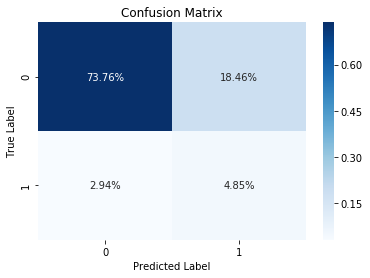

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [57]:
#for ROC/AUC Curve

lr_dec = lr_clf.decision_function(X_test1)

import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test1, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.6925563944415843

Test AUC: 0.7610059554453363


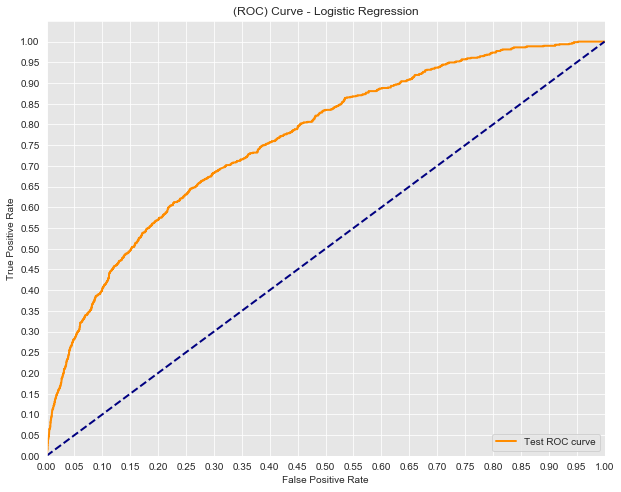

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test1, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [59]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test1, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.25


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.25')

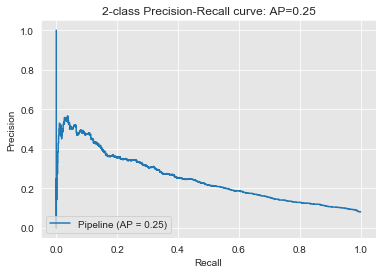

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test1, y_test1)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

# Logistic Regression Pre-Tokenized Text:

In [72]:
"""FOR PRE TOKENIZED TEXT ONLY"""

def dummy(doc):
     return doc

lr_clf_1 = Pipeline([('vect', CountVectorizer(tokenizer = dummy, preprocessor = dummy, max_df=0.9, max_features=1000)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8, random_state=2)),
              ])

# Logistic Regression Classifier

# lr_clf = LogisticRegression(class_weight='balanced', C=.8)

lr_clf_1.fit(X_train, y_train)

lr_y_pred_1 = lr_clf_1.predict(X_test)


print(confusion_matrix(y_test, lr_y_pred_1))
print(classification_report(y_test, lr_y_pred_1))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred_1)

TypeError: unhashable type: 'csr_matrix'

In [ ]:
test_4 = lr_clf_pt.predict(['A bill to designate postal office post office for forests in a forest of national veterans'])
test_4

# **Random Forest** - Regular Text

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_pipeline = Pipeline(steps=[('vectorizer', CountVectorizer(tokenizer = tokenizer)),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=100, class_weight="balanced", max_df=0.90, max_features=1000))])


rf_pipeline.fit(X_train1, y_train1) 

rf_y_pred = rf_pipeline.predict(X_test1)

print(confusion_matrix(y_test1, rf_y_pred))
print(classification_report(y_test1, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test1, rf_y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [ ]:
feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [ ]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

In [ ]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [ ]:
new_indices

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(1044), importances, align='center') 
    
    plt.yticks(np.arange(1044), feature_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)

# Comparing all Models:

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc